In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import shutil

In [2]:
import h5py

train_file = 'MA0035_4_m5_train.h5'
test_file = 'MA0035_4_m5_test.h5'

h5_train = h5py.File(train_file, 'r')
h5_test = h5py.File(test_file, 'r')

train_data = h5_train['data'][:90000]
train_binlabels = h5_train['binlabels'][:90000]

val_data = h5_train['data'][-10000:]
val_binlabels = h5_train['binlabels'][-10000:]

test_data = h5_test['data'][:]
test_binlabels = h5_test['binlabels'][:]

In [3]:
def train_model(hyperparameters, log_dir):
    board_log = log_dir + '/board'
    hparams_log = log_dir + '/hparams.json'

    my_callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir=board_log),
    ]

    with open(hparams_log, 'w') as hparam_file:
        json.dump(hyperparameters, hparam_file)

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(4, 1000)),
            tf.keras.layers.Dropout(hyperparameters['l0_dropout_rate']),
            tf.keras.layers.Dense(hyperparameters['l1_hidden_units'], activation=tf.keras.activations.relu),
            tf.keras.layers.Dropout(hyperparameters['l1_dropout_rate']),
            tf.keras.layers.Dense(hyperparameters['l2_hidden_units'], activation=tf.keras.activations.relu),
            tf.keras.layers.Dropout(hyperparameters['l2_dropout_rate']),
            tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
        ]
    )
    with tf.device('/GPU:0'):
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparameters['learning_rate']),
            loss = 'binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(name='auc')],
        )

        history = model.fit(train_data, train_binlabels,
                epochs=hyperparameters['epochs'], 
                validation_data=(val_data, val_binlabels),
                batch_size=hyperparameters['batch_size'],
                callbacks=my_callbacks)

    return model, history

In [4]:
def plot_and_save_roc(false_positive_rate, true_positive_rate, log_dir):
    roc = plt.figure(0)

    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    plt.savefig(log_dir + '/roc.pdf')
    pickle.dump(roc, open((log_dir + '/pickle/roc.fig.pickle'), 'wb'))

In [5]:
def plot_and_save_loss(history, log_dir):
    loss = plt.figure(1)
    history_loss = history.history['loss']
    history_val_loss = history.history['val_loss']
    epochs = range(len(history_loss))

    plt.plot(epochs, history_loss, 'ko', label='Training loss')
    plt.plot(epochs, history_val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.savefig(log_dir + '/loss.pdf')
    pickle.dump(loss, open((log_dir + '/pickle/loss.fig.pickle'), 'wb'))

In [6]:
def plot_and_save_auc(history, log_dir):
    auc = plt.figure(2)

    history_auc = history.history['auc']
    history_val_auc = history.history['val_auc']
    epochs = range(len(history_auc))

    plt.plot(epochs, history_auc, 'ko', label='Training auc')
    plt.plot(epochs, history_val_auc, 'b', label='Validation auc')
    plt.title('Training and validation auc')
    plt.ylim(0.46, 1.0)
    plt.legend()

    plt.savefig(log_dir + '/auc.pdf')
    pickle.dump(auc, open((log_dir + '/pickle/auc.fig.pickle'), 'wb'))

In [7]:
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

4 [==============================] - 3s 4ms/step - loss: 0.6086 - auc: 0.5843 - val_loss: 0.6235 - val_auc: 0.4966
Epoch 54/200
704/704 [==============================] - 3s 4ms/step - loss: 0.6076 - auc: 0.5883 - val_loss: 0.6237 - val_auc: 0.4967
Epoch 55/200
704/704 [==============================] - 3s 4ms/step - loss: 0.6085 - auc: 0.5888 - val_loss: 0.6239 - val_auc: 0.4965
Epoch 56/200
704/704 [==============================] - 3s 4ms/step - loss: 0.6066 - auc: 0.5932 - val_loss: 0.6241 - val_auc: 0.4963
Epoch 57/200
704/704 [==============================] - 3s 4ms/step - loss: 0.6044 - auc: 0.5974 - val_loss: 0.6243 - val_auc: 0.4965
Epoch 58/200
704/704 [==============================] - 3s 4ms/step - loss: 0.6067 - auc: 0.5972 - val_loss: 0.6246 - val_auc: 0.4962
Epoch 59/200
704/704 [==============================] - 3s 4ms/step - loss: 0.6046 - auc: 0.6035 - val_loss: 0.6249 - val_auc: 0.4958
Epoch 60/200
704/704 [==============================] - 3s 4ms/step - loss: 0.601

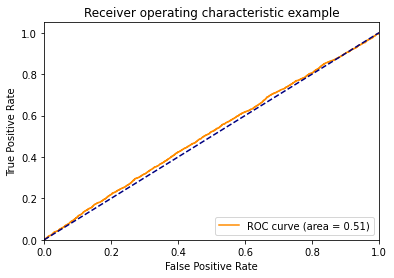

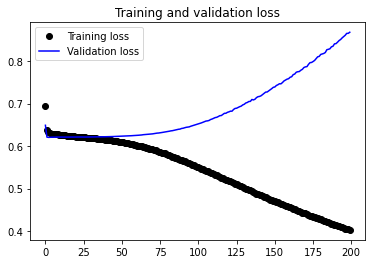

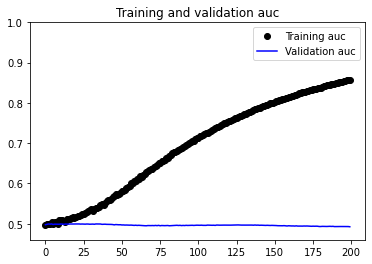

In [8]:
L0_DROPOUT_RATES = [0.0] #0.8 makes things useless, try 0.7
L1_DROPOUT_RATES = [0.0]
L2_DROPOUT_RATES = [0.4]
L1_HIDDEN_UNITS = [16]
L2_HIDDEN_UNITS = [128]
BATCH_SIZE = [32, 64, 128, 254, 512]
LEARNING_RATE = [0.000006]

for l1_hidden_units in L1_HIDDEN_UNITS:
    for learning_rate in LEARNING_RATE:
        for l0_dropout_rate in L0_DROPOUT_RATES:
            for l1_dropout_rate in L1_DROPOUT_RATES:
                log_dir = './logs/1_layer_dropout_test/' + 'l1h' + str(l1_hidden_units) + '\l2h' + str(L2_HIDDEN_UNITS[0]) + '\l0d' + str(l0_dropout_rate) + '\l1d' + str(l1_dropout_rate) + '\l2d' + str(L2_DROPOUT_RATES[0]) + '\lr' + str(learning_rate)
                
                try:
                    shutil.rmtree(log_dir)
                except OSError as e:
                    print(e)

                try:
                    os.makedirs(log_dir)
                    os.makedirs(log_dir + '/pickle')
                except OSError as e:
                    print(e)

                hparams = {
                    'l0_dropout_rate': l0_dropout_rate,
                    'l1_dropout_rate': l1_dropout_rate,
                    'l2_dropout_rate': L2_DROPOUT_RATES[0],
                    'l1_hidden_units': l1_hidden_units,
                    'l2_hidden_units': L2_HIDDEN_UNITS[0],
                    'learning_rate': learning_rate,
                    'batch_size': BATCH_SIZE[2],
                    'epochs': 200,
                }

                model, history = train_model(hparams, log_dir)

                acc, auc = model.evaluate(test_data, test_binlabels)
                yhat = model.predict(test_data)
                fpr, tpr, _ = roc_curve(test_binlabels, yhat)
                roc_auc = roc_auc_score(test_binlabels, yhat)

                plot_and_save_roc(fpr, tpr, log_dir)
                plot_and_save_loss(history, log_dir)
                plot_and_save_auc(history, log_dir)

                plt.show()